# Recommender Systems

# Библиотеки

In [ ]:
!pip install implicit

In [ ]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm


# Данные

В качестве данных будем использовать датасет от Кино.Триколор.
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами.

**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users_df.csv`) и описание айтемов(`items_df.csv`).

In [ ]:
data_folder = ""

users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"movie_id": list}).reset_index()


# Пользователи

In [ ]:
users_df.head(10)

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее
5,46037,25-34,низкий,Мужской,0.0,Среднее
6,15060,18-24,средний,Мужской,0.0,Без образования
7,38702,NaN,высокий,Мужской,0.0,NaN
8,2019,25-34,низкий,Женский,NaN,NaN
9,34480,25-34,низкий,Женский,1.0,Высшее


## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age_category` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя
6. `education` – уровень образования пользователя

# Айтемы

In [ ]:
items_df.head(4)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,Вторая мировая война подходит к концу. В это в...,"[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 1663...",NaN,NaN,NaN


## Какие есть признаки?

1. `id` – индентификатор айтема, уникален для каждого
2. `title` – Название на русском языке
3. `year` – Дата выхода
4. `date_publication` – дата публикации на платформе
5. `description` – описание (на русском)
6. `genres` - список жанров (представлен строкой)
7. `countries` – страна издания
8. `staff` – режиссер(ы), актёры
9. `title_orig` – название на английском
10. `age_rating` – возрастной рейтинг картины
11. `keywords` – ключевые слова, описывающие картину

# Страны выпуска фильмов

In [ ]:
countries.head()

,id,name
0,0,Франция
1,1,Мальта
2,5,Новая Зеландия
3,8,Куба
4,10,Пуэрто-Рико


# Жанры

In [ ]:
genres.head()

,id,name
0,2,Сказка
1,8,Здоровье
2,17,Наука
3,24,Комедийная мелодрама
4,38,Мистика


# Актеры, режиcсеры

In [ ]:
staff.head(2)

,id,name,role
0,0,Юрий Волынцев,actor
1,1,Коннор Смит,actor


# Просмотры пользователей

### Тренировачные данные

In [ ]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,251,871


,id,datetime,user_id,movie_id,duration,is_train
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0,True
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0,True
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0,True
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0,True
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0,True


Сразу начну проводить разведывательный анализ и по ходу дела предобработку данных

In [ ]:
train_part.isna().sum()

,0
id,0
datetime,0
user_id,0
movie_id,0
duration,0
is_train,0


In [ ]:
train_part.isnull().sum()

,0
id,0
datetime,0
user_id,0
movie_id,0
duration,0
is_train,0


Пропусков нет, уже хорошо

In [ ]:
train_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251871 entries, 0 to 1251870
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   id        1251871 non-null  int64  
 1   datetime  1251871 non-null  object 
 2   user_id   1251871 non-null  int64  
 3   movie_id  1251871 non-null  float64
 4   duration  1251871 non-null  float64
 5   is_train  1251871 non-null  bool   
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 48.9+ MB


In [ ]:
train = train_part.copy() #на всякий случай

In [ ]:
train['movie_id'] = train['movie_id'].astype(int) #приводим типы
train['duration'] = train['duration'].astype(int)
train = train.drop('is_train', axis=1) #мы и так знаем, что это train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251871 entries, 0 to 1251870
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   id        1251871 non-null  int64 
 1   datetime  1251871 non-null  object
 2   user_id   1251871 non-null  int64 
 3   movie_id  1251871 non-null  int64 
 4   duration  1251871 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 47.8+ MB


In [ ]:
train_part.describe()

,id,user_id,movie_id,duration
count,1.251871e+06,1.251871e+06,1.251871e+06,1.251871e+06
mean,9.089418e+05,4.256487e+04,3.696708e+03,2.796361e+03
std,5.885869e+05,5.535238e+04,2.129806e+03,2.736542e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.118625e+05,5.954000e+03,1.871000e+03,2.010000e+02
50%,8.674890e+05,1.968700e+04,3.672000e+03,1.862000e+03
75%,1.339846e+06,5.533800e+04,5.584000e+03,5.181000e+03
max,2.477903e+06,2.638740e+05,7.426000e+03,4.573800e+04


In [ ]:
import plotly.express as px

In [ ]:
fig = px.histogram(train_part.sample(500_000), x='movie_id',
                   title='Распределение фильмов')
fig.show()

Видим, что есть довольно популярные фильмы, а есть напротив - фильмы, которые мало кто смотрел. Вопрос: как соотносится их количество?

In [ ]:
df = train[['movie_id','user_id']].groupby('movie_id')['user_id'].agg('count').to_frame()
df.rename(columns={'user_id':'views'}, inplace= True)
df = df.sort_values('views', ascending=False)
df.head()

,views
movie_id,
484,17053
6194,6853
641,4830
2679,4789
2820,4662


In [ ]:
df.describe()

,views
count,5269.000000
mean,237.591763
std,498.162580
min,1.000000
25%,21.000000
50%,82.000000
75%,253.000000
max,17053.000000


In [ ]:
train1 = train.copy()
train1 = train1.merge(df, on='movie_id', how='left')
train1 = train1[train1['views'] > 21] #граница первого квантиля. Чтобы составлять рекомендации нам нужна неплохая выборка
train1.head()

,id,datetime,user_id,movie_id,duration,views
0,0,2023-04-06 15:00:00.071114+03:00,10250,427,485,189
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521,129,3477
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598,2795,833
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324,5094,311
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291,75,713


In [ ]:
train1.describe()

,id,user_id,movie_id,duration,views
count,1.239474e+06,1.239474e+06,1.239474e+06,1.239474e+06,1.239474e+06
mean,9.087296e+05,4.253082e+04,3.696612e+03,2.810352e+03,1.294591e+03
std,5.882096e+05,5.532037e+04,2.129318e+03,2.738566e+03,2.170071e+03
min,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,2.200000e+01
25%,4.122152e+05,5.957000e+03,1.873000e+03,2.050000e+02,3.020000e+02
50%,8.669800e+05,1.967300e+04,3.672000e+03,1.892000e+03,6.980000e+02
75%,1.339347e+06,5.525300e+04,5.584000e+03,5.191000e+03,1.517000e+03
max,2.477903e+06,2.638740e+05,7.426000e+03,4.573800e+04,1.705300e+04


In [ ]:
train1 = train1[(train1['duration'] >= 205) & (train1['duration'] <= 5191)] #убираем выбросы

In [ ]:
train1['datetime'] = pd.to_datetime(train1['datetime']).dt.year #для простоты будем смотреть только год

In [ ]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 620277 entries, 0 to 1251870
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   id        620277 non-null  int64
 1   datetime  620277 non-null  int32
 2   user_id   620277 non-null  int64
 3   movie_id  620277 non-null  int64
 4   duration  620277 non-null  int64
 5   views     620277 non-null  int64
dtypes: int32(1), int64(5)
memory usage: 30.8 MB


In [ ]:
df2 = train1[['movie_id','user_id']].groupby('user_id')['movie_id'].agg('count').to_frame()
df2.rename(columns={'movie_id':'watched_number'}, inplace= True)
df2.head()

,watched_number
user_id,
0,7
1,14
2,1
3,57
4,49


In [ ]:
df2.describe()

,watched_number
count,139603.000000
mean,4.443150
std,7.291028
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,143.000000


Тут становится понятно, что большинство людей посмотрело не более 2 фильмов, поэтому разумно рекомендовать им фильмы в том же жанре, которые находятся в топе просмотров у всех пользователей


In [ ]:
mini_items = items_df[["id", "genres"]]
mini_items.rename(columns={'id':'movie_id'}, inplace= True)
mini_items['genres'] = mini_items['genres'].apply(lambda x: list(x[1:-1].split(sep = ','))) # чтобы в жанрах был лист, а не строка
mini_items.head()

<ipython-input-30-49504edbf5f7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-49504edbf5f7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,movie_id,genres
0,0,[97]
1,1,"[138, 97, 294]"
2,2,"[294, 302]"
3,3,"[97, 303, 143, 319]"
4,4,"[138, 97]"


In [ ]:
top = df.copy()

In [ ]:
top = top.merge(mini_items, on='movie_id', how='left')
top.head()

,movie_id,views,genres
0,484,17053,"[158, 294, 266, 302]"
1,6194,6853,"[97, 303, 143, 319]"
2,641,4830,[218]
3,2679,4789,"[97, 158, 294, 266, 302]"
4,2820,4662,[261]


In [ ]:
top10 = top.copy()
top10['genres'] = top10['genres']
top10 = top10.explode("genres")
top10 = top10.sort_values(['genres','views'],ascending=False).groupby('genres').head(10) #топ 10 по каждому жанру
top10.head(20)

,movie_id,views,genres
1,6194,6853,97
3,2679,4789,97
5,5876,4455,97
6,5336,4434,97
9,2480,4084,97
11,1281,3930,97
20,2893,3247,97
21,4314,3230,97
32,1646,2552,97
39,5717,2380,97


### Тестовые данные

In [ ]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 66,900


,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ..."


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается.
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`duration`), а так же дату последнего просмотра (`datetime`)
#### При этом на тестовых данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [ ]:
# ACHTUNG! DO NOT TOUCH

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [ ]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [ ]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "movie_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train1)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,movie_id,toppopular_recs
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[484, 2820, 1978, 1521, 5849, 6194, 6091, 5336..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[484, 2820, 1978, 1521, 5849, 6194, 6091, 5336..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[484, 2820, 1978, 1521, 5849, 6194, 6091, 5336..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0...","[484, 2820, 1978, 1521, 5849, 6194, 6091, 5336..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ...","[484, 2820, 1978, 1521, 5849, 6194, 6091, 5336..."


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [ ]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.11184163511741943, 'recall': 0.050473959793412314}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички.
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули.

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички.
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.


# Baseline #2 – Матричное разложение

In [ ]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)
        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning:

OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.



  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/66900 [00:00<?, ?it/s]

#### Снова считаем метрики

In [ ]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.07245869600756492, 'recall': 0.03303704639228699}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

Но перед этим попробуем посмотреть, что будет если использовать тот же метод на предобработанных данных. Для этого нужно немного изменить код: в тестовой выборке есть юзеры, которых нет в train1. Давайте это исправим

In [ ]:
train2 = train.copy()
train2 = train2.merge(df, on='movie_id', how='left')
train2 = train2[train2['user_id'].isin(test_part['user_id'])]
# train2['datetime'] = pd.to_datetime(train2['datetime']).dt.year
train2['datetime'] = train2['datetime'].apply(lambda x: np.int32(x[:4])) # к сожалению, в данных есть несоответствие формату, поэтому сделать как выше не получится
train2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 868251 entries, 0 to 1156416
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   id        868251 non-null  int64
 1   datetime  868251 non-null  int32
 2   user_id   868251 non-null  int64
 3   movie_id  868251 non-null  int64
 4   duration  868251 non-null  int64
 5   views     868251 non-null  int64
dtypes: int32(1), int64(5)
memory usage: 43.1 MB


In [ ]:
train2[train2['user_id'].isin(train1['user_id'])].info()

<class 'pandas.core.frame.DataFrame'>
Index: 850483 entries, 0 to 1156416
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   id        850483 non-null  int64
 1   datetime  850483 non-null  int32
 2   user_id   850483 non-null  int64
 3   movie_id  850483 non-null  int64
 4   duration  850483 non-null  int64
 5   views     850483 non-null  int64
dtypes: int32(1), int64(5)
memory usage: 42.2 MB


Видим, что таблицы почти совпадают, так что впоследствии будем прогонять на train2

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

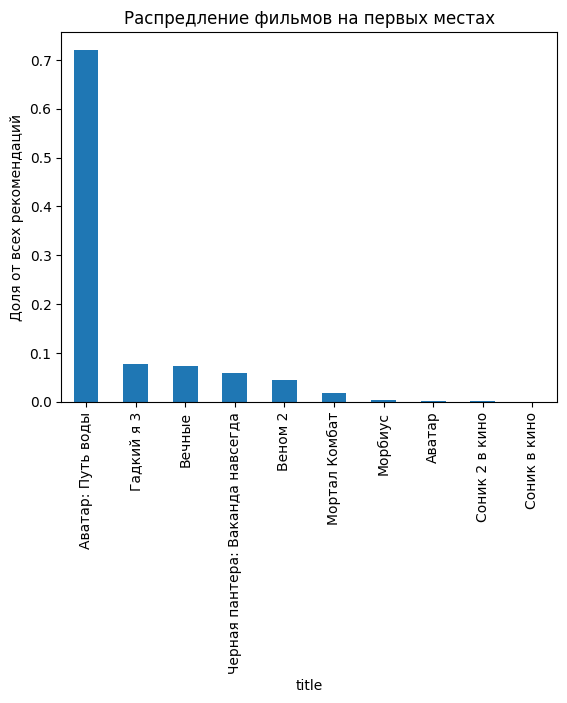

In [ ]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["id"])
first_items = (
    first_items.merge(items_df[["id", "title"]], on="id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


#### Посмотрим на похожие фильмы к фильму "Аватар: Путь воды", согласно als

In [ ]:
items_df[items_df["title"] == 'Аватар: Путь воды']

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
484,484,Аватар: Путь воды,2023-01-01,2023-04-19T00:00:00,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481...",NaN,NaN,NaN


In [ ]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["id"].isin(similar_ids)]["title"]


In [ ]:
get_similar_films("Аватар: Путь воды")

,title
1667,31 июня
2848,Великий уравнитель 2
3078,Безымянная звезда
3088,Скандинавский форсаж: Гонки на льду
4003,Сердце из стали
4584,Проповедник
5141,Сестрица Алёнушка и братец Иванушка
6837,Синяя бездна
7043,Обратная связь
7343,Приключения на шоколадной фабрике


#### Получается, что "Аватар: Путь воды" и "31 июня" довольно близки.... возможно, возможно

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).


Сперва сделаю так, чтобы ALS учитывал не только user_id, movie_id, но и остальные колонки(для начала жанры):

In [ ]:
my_items = items_df.copy()
my_items['genres'] = my_items['genres'].apply(lambda x: x[1:-1].split(sep=','))
my_items = my_items.explode('genres')
my_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13797 entries, 0 to 7426
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                13797 non-null  int64  
 1   title             13797 non-null  object 
 2   year              13797 non-null  object 
 3   date_publication  9810 non-null   object 
 4   description       13519 non-null  object 
 5   genres            13797 non-null  object 
 6   countries         13797 non-null  object 
 7   staff             13797 non-null  object 
 8   title_orig        6004 non-null   object 
 9   age_rating        6615 non-null   float64
 10  keywords          6593 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.3+ MB


In [ ]:
my_items = my_items[my_items['id'].isin(train2['movie_id'])]
my_items = my_items[['id', 'genres']]
my_items.rename(columns={'id':'movie_id'}, inplace= True)
my_items.head()

,movie_id,genres
0,0,97
3,3,97
3,3,303
3,3,143
3,3,319


In [ ]:
my_train = train2.copy()
my_train = my_train.merge(my_items, on='movie_id', how='left')
my_train.head()

,id,datetime,user_id,movie_id,duration,views,genres
0,0,2023,10250,427,485,189,97
1,1,2023,2062,1521,129,3477,46
2,1,2023,2062,1521,129,3477,266
3,1,2023,2062,1521,129,3477,304
4,1,2023,2062,1521,129,3477,130


In [ ]:
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

class myALS(BaseRecommender):

    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "movie_id", genre_col: str = "genres", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.genre_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        genre_ids = self.genre_encoder.fit_transform(df[genre_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape1 = len(self.user_encoder.classes_), len(self.item_encoder.classes_)
        matrix_shape2 = len(self.item_encoder.classes_), len(self.genre_encoder.classes_)
        matrix_shape3 = len(self.genre_encoder.classes_), len(self.item_encoder.classes_)
        arr1 = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape1).toarray()
        arr2 = normalize_2d(csr_matrix((counts, (item_ids, genre_ids)), shape=matrix_shape2).toarray())
        arr2 = np.dot(arr2, arr2.T)
        arr1 = np.dot(arr1, arr2)
        self.sparse = csr_matrix(arr1)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
als_rec = myALS(iterations=1, factors=2, random_state=42)
als_rec.fit(my_train)
test_part["als_recs"] = als_rec.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/66900 [00:00<?, ?it/s]

In [ ]:
evaluate_recommender(test_part, model_preds_col="als_recs")

{'ndcg': 0.01474179027601629, 'recall': 0.005842974489741015}

Как видим, результаты оставляют желать лучшего. Скорее всего это связано с тем, что, как я уже упоминал, большая часть людей посмотрели не более 2 фильмов, соответственно стандартные алгоритмы ML не будут работать на такой маленькой выборке, так что лучшим вариантом остается рекомендовать топ10 самых популярных фильмов.